In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from IPython.display import display
from scipy import stats
from collections import OrderedDict
import celerite
from celerite import terms

In [7]:
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
display(train_meta.head())

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [2]:
train_ts = pd.read_csv("../data/input/training_set.csv")
display(train_ts.head())

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [3]:
def _find_peak(extract_passband):
    import warnings
    warnings.filterwarnings("ignore")
    
    extract_passband["flux_add_err"] = extract_passband["flux"] + extract_passband["flux_err"]
    peak_flux = extract_passband["flux"].max()
    peak_point = extract_passband[extract_passband.flux == peak_flux]["mjd"].values[0]

    data_before_peak = extract_passband.query('mjd < @peak_point')
    data_after_peak = extract_passband.query('mjd > @peak_point')

    min_flux_before = extract_passband["flux"].min()
    min_flux_after = extract_passband["flux"].min()
    flux_diff_before = peak_flux - min_flux_before
    flux_diff_after = peak_flux - min_flux_after

    result_list = []
    thres_per_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    result_after = []
    for thres_per in thres_per_list:
        thres = min_flux_before + flux_diff_before * thres_per
        point = data_after_peak.query("flux < @thres")["mjd"].min()
        diff_point = point - peak_point
        result_after.append(diff_point)
    result_list.extend(result_after)

    result_before = []
    for thres_per in thres_per_list:
        thres = min_flux_after + flux_diff_after * thres_per
        point = data_before_peak.query("flux < @thres")["mjd"].max()
        diff_point = peak_point - point
        result_before.append(diff_point)
    result_list.extend(result_before)

    result_diff = []
    for af, bef in zip(result_after, result_before):
        result_diff.append(af + bef)
    result_list.extend(result_diff)

    return result_after, result_before, result_diff

In [18]:
def _find_peak(extract_passband):
    import warnings
    warnings.filterwarnings("ignore")
    extract_passband["flux_add_err"] = extract_passband["flux"] + extract_passband["flux_err"]
    peak_flux = extract_passband["flux"].max()
    peak_point = extract_passband[extract_passband.flux == peak_flux]["mjd"].values[0]

    data_before_peak = extract_passband.query('mjd < @peak_point')
    data_after_peak = extract_passband.query('mjd > @peak_point')

    # min_flux_before = data_before_peak["flux"].min()
    # min_flux_after = data_after_peak["flux"].min()
    min_flux_before = extract_passband["flux"].min()
    min_flux_after = extract_passband["flux"].min()
    flux_diff_before = peak_flux - min_flux_before
    flux_diff_after = peak_flux - min_flux_after

    result_list = []
    thres_per_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    result_after = []
    for thres_per in thres_per_list:
        thres = min_flux_before + flux_diff_before * thres_per
        point = data_after_peak.query("flux < @thres")["mjd"].min()
        diff_point = point - peak_point
        result_after.append(diff_point)
    result_list.extend(result_after)

    result_before = []
    for thres_per in thres_per_list:
        thres = min_flux_after + flux_diff_after * thres_per
        point = data_before_peak.query("flux < @thres")["mjd"].max()
        diff_point = peak_point - point
        result_before.append(diff_point)
    result_list.extend(result_before)

    result_diff = []
    for af, bef in zip(result_after, result_before):
        result_diff.append(af + bef)
    result_list.extend(result_diff)

    return result_list

In [9]:
train_meta.iloc[2874]["object_id"]

17694609.0

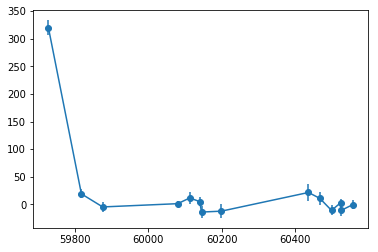

[89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [19]:
sample = train_ts.query('object_id == 17694609 & passband == 0')
x = sample["mjd"]
y = sample["flux"]
y_err = sample["flux_err"]
plt.scatter(x, y)
plt.errorbar(x, y, y_err)
plt.show()

_find_peak(sample)

In [23]:
def find_peak(extract_obj):
    object_id = extract_obj["object_id"].unique()[0]
    passband_list = [0, 1, 2, 3, 4, 5]

    result_list = [object_id]
    for passband in passband_list:
        result = _find_peak(extract_obj.query('passband == @passband'))
        result_list.extend(result)
        print(passband, result)

    return result_list

In [29]:
passband_list = [0, 1, 2, 3, 4, 5]
thres_per_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colname_list = []
for passband in passband_list:
    for which in ['after', 'before', 'diff']:
        for thres in thres_per_list:
            colname_list.append(f'time_from_peak_{which}_thres{thres}_pass{passband}')
colname_list

['time_from_peak_after_thres0.1_pass0',
 'time_from_peak_after_thres0.2_pass0',
 'time_from_peak_after_thres0.3_pass0',
 'time_from_peak_after_thres0.4_pass0',
 'time_from_peak_after_thres0.5_pass0',
 'time_from_peak_after_thres0.6_pass0',
 'time_from_peak_after_thres0.7_pass0',
 'time_from_peak_after_thres0.8_pass0',
 'time_from_peak_after_thres0.9_pass0',
 'time_from_peak_before_thres0.1_pass0',
 'time_from_peak_before_thres0.2_pass0',
 'time_from_peak_before_thres0.3_pass0',
 'time_from_peak_before_thres0.4_pass0',
 'time_from_peak_before_thres0.5_pass0',
 'time_from_peak_before_thres0.6_pass0',
 'time_from_peak_before_thres0.7_pass0',
 'time_from_peak_before_thres0.8_pass0',
 'time_from_peak_before_thres0.9_pass0',
 'time_from_peak_diff_thres0.1_pass0',
 'time_from_peak_diff_thres0.2_pass0',
 'time_from_peak_diff_thres0.3_pass0',
 'time_from_peak_diff_thres0.4_pass0',
 'time_from_peak_diff_thres0.5_pass0',
 'time_from_peak_diff_thres0.6_pass0',
 'time_from_peak_diff_thres0.7_pass0'

In [24]:
find_peak(train_ts.query('object_id == 17694609'))

0 [89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, 89.76890000000276, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
1 [269.1171000000031, 269.1171000000031, 269.1171000000031, 269.1171000000031, 269.1171000000031, 269.1171000000031, 23.895799999998417, 23.895799999998417, 20.886200000000827, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
2 [298.98779999999533, 298.98779999999533, 298.98779999999533, 64.64619999999559, 51.709600000001956, 51.709600000001956, 51.709600000001956, 23.813300000001618, 23.813300000001618, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
3 [327.0772999999972, 327.0772999999972, 327.0772999999972, 109.68789999999717, 109.68789999999717, 83.95240000000194, 83.95240000000194, 83.95240000000194, 83.95240000000194, nan, nan, nan, nan, n

[17694609,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 89.76890000000276,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 269.1171000000031,
 269.1171000000031,
 269.1171000000031,
 269.1171000000031,
 269.1171000000031,
 269.1171000000031,
 23.895799999998417,
 23.895799999998417,
 20.886200000000827,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 298.98779999999533,
 298.98779999999533,
 298.98779999999533,
 64.64619999999559,
 51.709600000001956,
 51.709600000001956,
 51.709600000001956,
 23.813300000001618,
 23.813300000001618,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 327.0772999999972,
 327.0772999999972,
 327.0772999999972,
 109.68789999999717,
 109.68789999999717,
 83.95240000